<a href="https://colab.research.google.com/github/nahyeon-an/python/blob/main/ML/time-series/Trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


### Trend  
persistent, long-term change 를 나타내는 요소  
중요성의 가장 큰 시간 규모를 나타내는 slowest-moving part  

### Moving Average Plot  
트렌드를 보기위한 방법 중 하나  
슬라이딩 윈도를 이용해 값들의 평균을 구함  
단기적인 변동을 smooth -> 장기적인 변화만 남게  
(단기적인 변동 -> seasonal change)  

trend 모델링  
- time-step 피처를 이용하여 가능  
- linear trend model : target = a \* time + b  
- time dummy 에 여러 변형을 통해 다양한 트렌드 모델링 가능  
- ex) target = a \* time \*\* 2 + b \* time + c  
- Linear regression 은 a, b, c 를 학습  

In [ ]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
simplefilter("ignore")

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [ ]:
tunnel = pd.read_csv('tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day').to_period()
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [ ]:
# 1. rolling : window computation (compute average)
moving_average = tunnel.rolling(
    window=365,  # window size
    center=True,  # average center
    min_periods=183,  # half of window size
).mean()  # mean, median, std, min, max, ...

moving_average

,NumVehicles
Day,
2003-11-01,99127.426230
2003-11-02,99094.489130
2003-11-03,99112.481081
2003-11-04,99146.639785
2003-11-05,99196.122995
...,...
2005-11-12,112995.689840
2005-11-13,113058.763441
2005-11-14,113195.718919


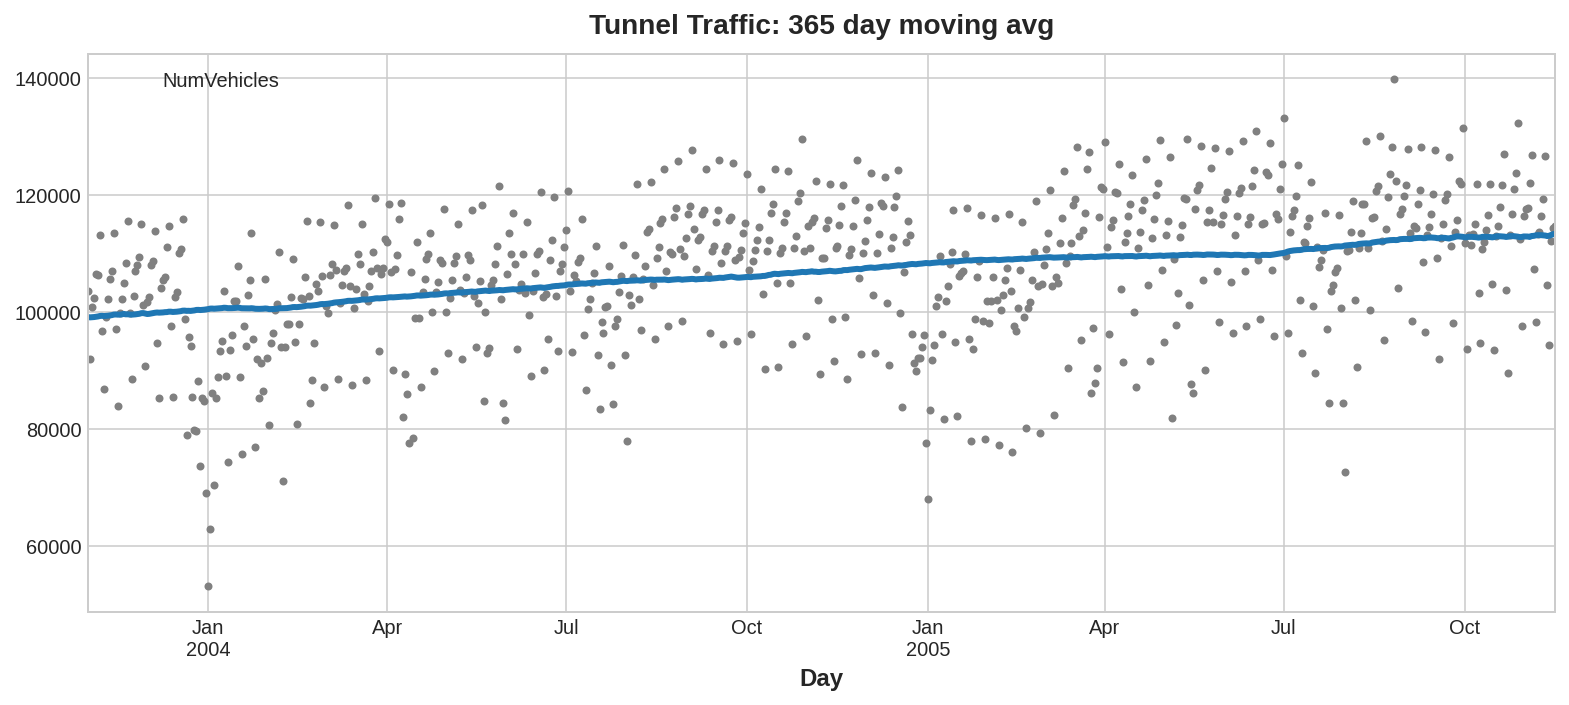

In [ ]:
ax = tunnel.plot(style='.', color='0.5')
moving_average.plot(
    ax=ax, linewidth=3, title='Tunnel Traffic: 365 day moving avg', legend=False
)

statsmodels 의 DeterministicProcess 를 사용해보자  
- 시계열과 linear regression 을 이용할 때 발생가능한 tricky fail 을 피하기 위한 방법  
- order = polynomial order (1: linear, 2: quadratic, 3: cubic, ...)  

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [ ]:
dp = DeterministicProcess(
    index=tunnel.index,  # 학습셋에서 dates
    constant=True,  # dummy feature for bias (y절편)
    order=1,  # time dummy
    drop=True,  # collinearity 를 피해야할 때 true
)
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


deterministic process  
- 시계열이 non-random 이거나 constant, trend 가 완전히 결정되었을 때를 위한 방법  
- time index 에서 만들어진 피처도 deterministic  

In [ ]:
from sklearn.linear_model import LinearRegression

y = tunnel['NumVehicles']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [ ]:
y_pred.head()

Day
2003-11-01    98176.206344
2003-11-02    98198.703794
2003-11-03    98221.201243
2003-11-04    98243.698693
2003-11-05    98266.196142
Freq: D, dtype: float64

moving average 플롯과 동일한 결과를 볼 수 있음  
- linear trend 가 좋은 결정이었음을 보여줌  

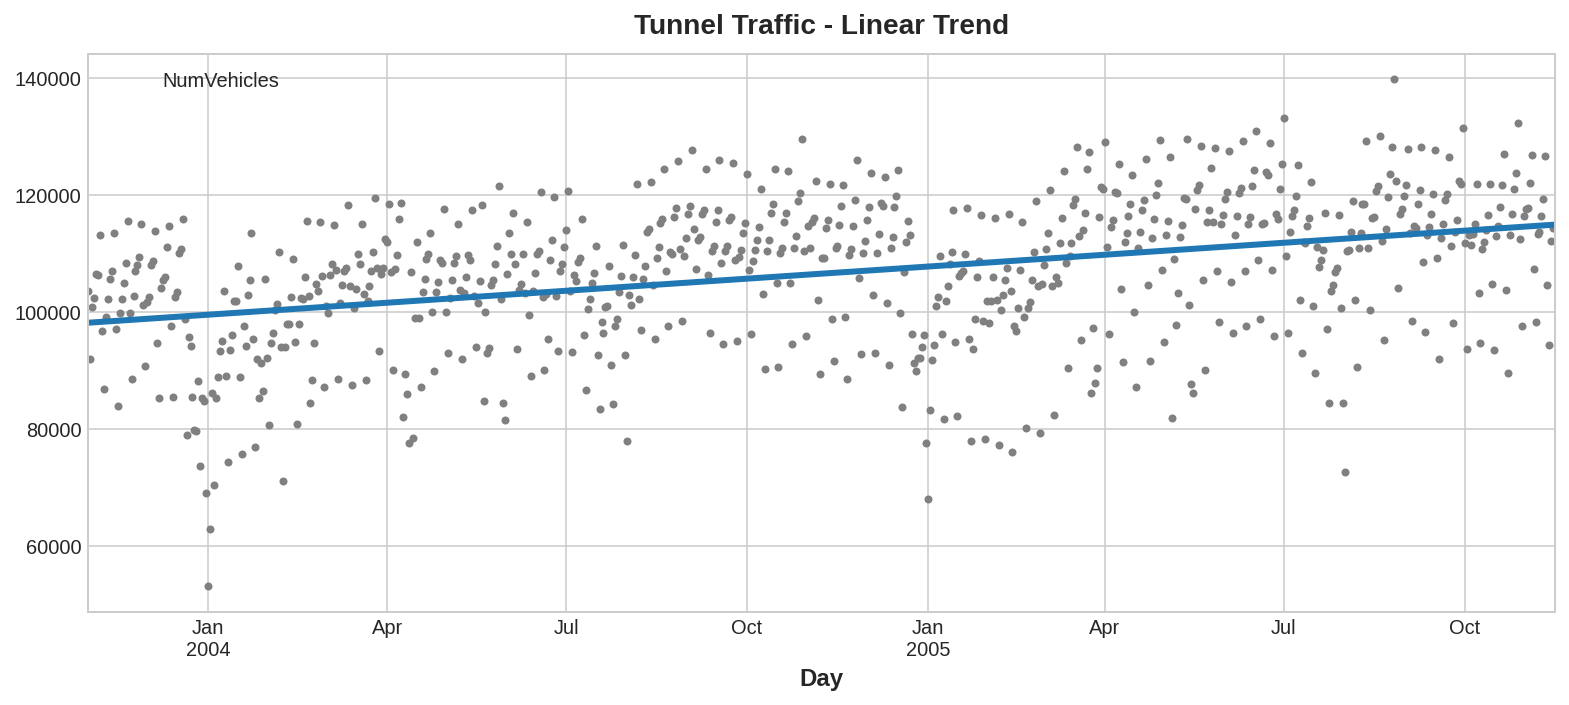

In [ ]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

예측을 위해 "out of sample" 피처를 모델에 적용  
out of sample : 훈련셋의 관측 기간을 벗어나는 시간  

In [ ]:
X = dp.out_of_sample(steps=30)
y_forecast = pd.Series(model.predict(X), index=X.index)

y_forecast.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

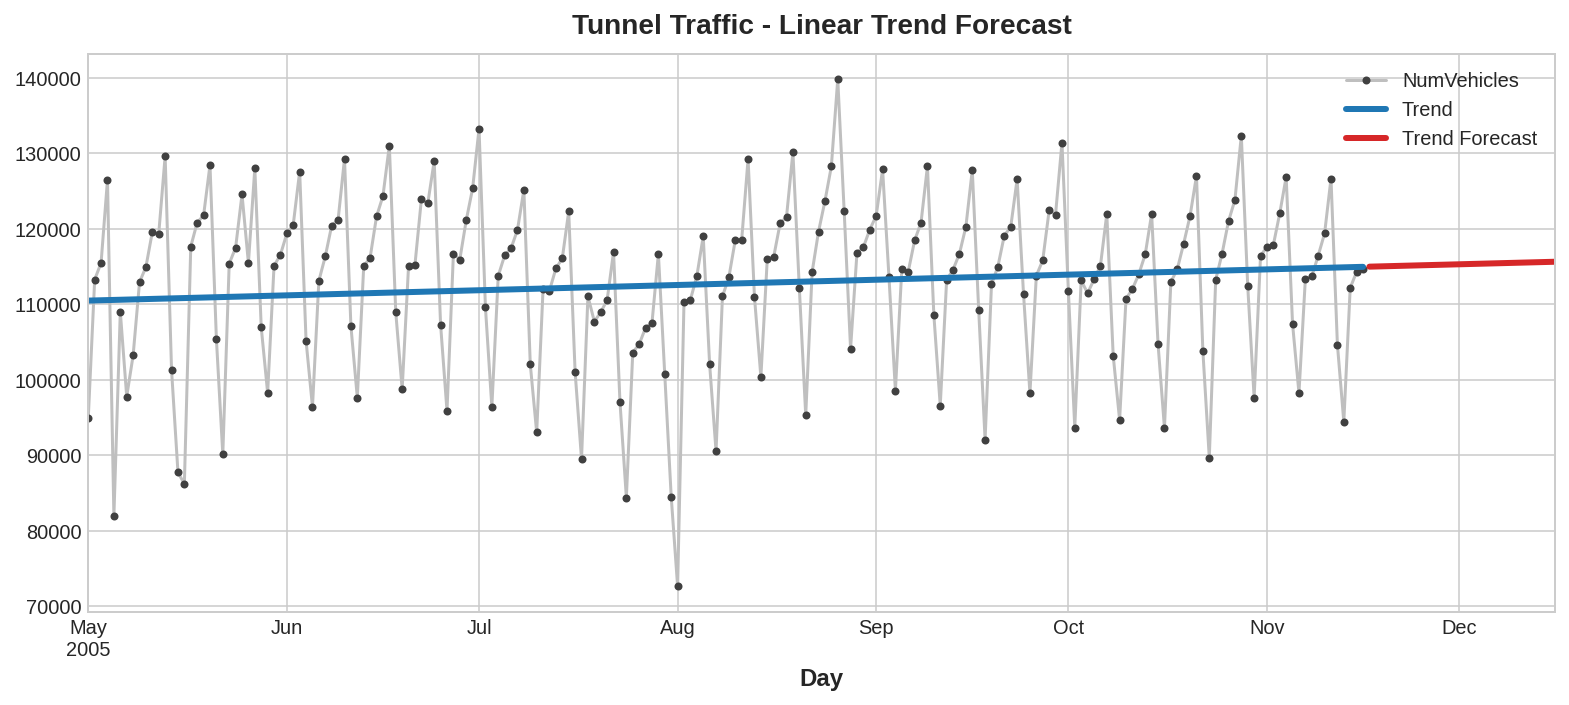

In [ ]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_forecast.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

### Exercise

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [9]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
retail_sales = pd.read_csv(
    'us-retail-sales.csv',
    parse_dates=['Month'],
    index_col='Month'
).to_period('D')

food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

In [4]:
food_sales.head()

Month
1992-01-01    29589
1992-02-01    28570
1992-03-01    29682
1992-04-01    30228
1992-05-01    31677
Freq: D, Name: FoodAndBeverage, dtype: int64

In [5]:
auto_sales.head()

Month
1992-01-01    26788
1992-02-01    28203
1992-03-01    31684
1992-04-01    32547
1992-05-01    32883
Freq: D, Name: Automobiles, dtype: int64

In [6]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [7]:
store_sales.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

In [8]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

#### 1. moving average plot 을 이용한 트렌드 결정 

[Text(0, 0.5, 'Millions of Dollars'),
 Text(0.5, 1.0, 'US Food and Beverage Sales')]

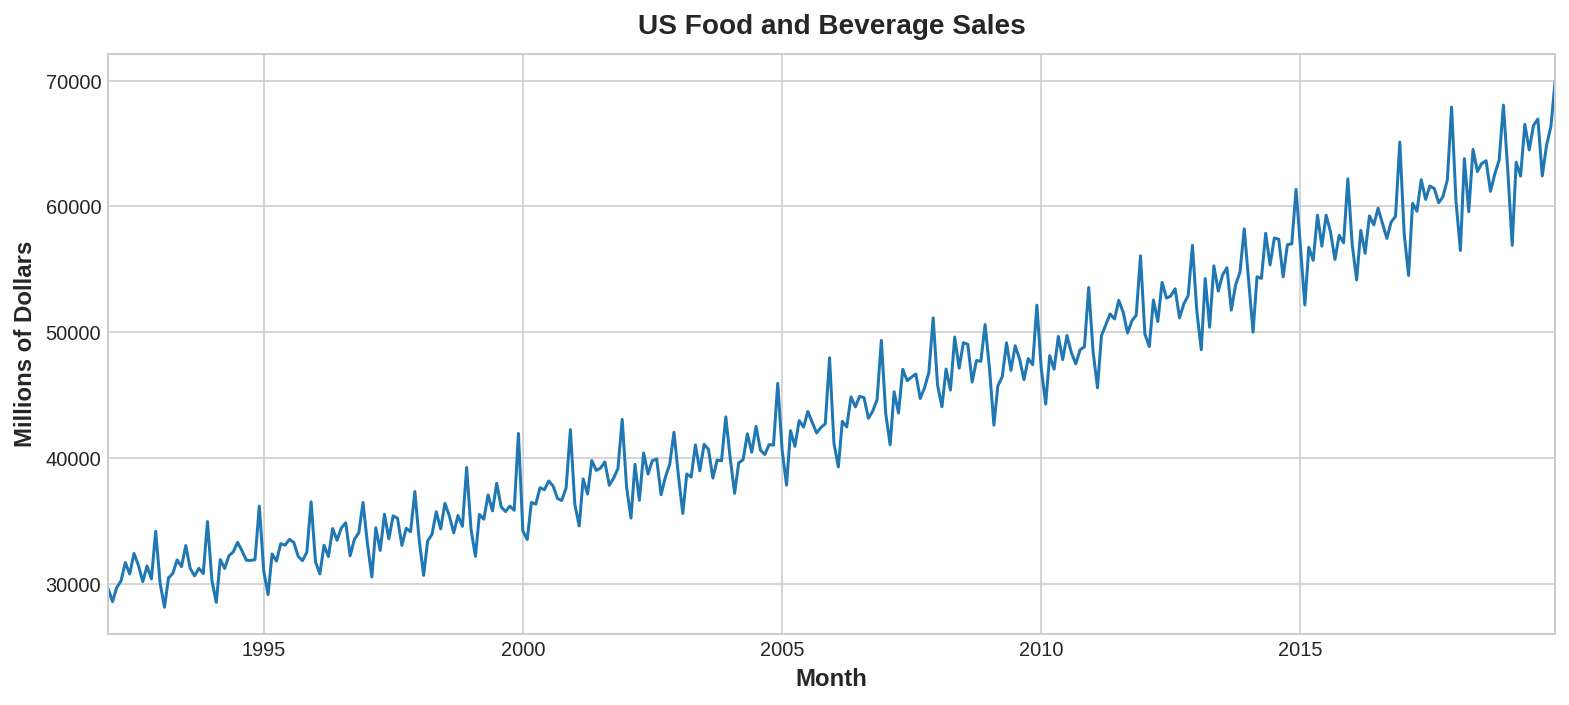

In [10]:
# 기본 시계열 플롯 확인
ax = food_sales.plot()
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars")

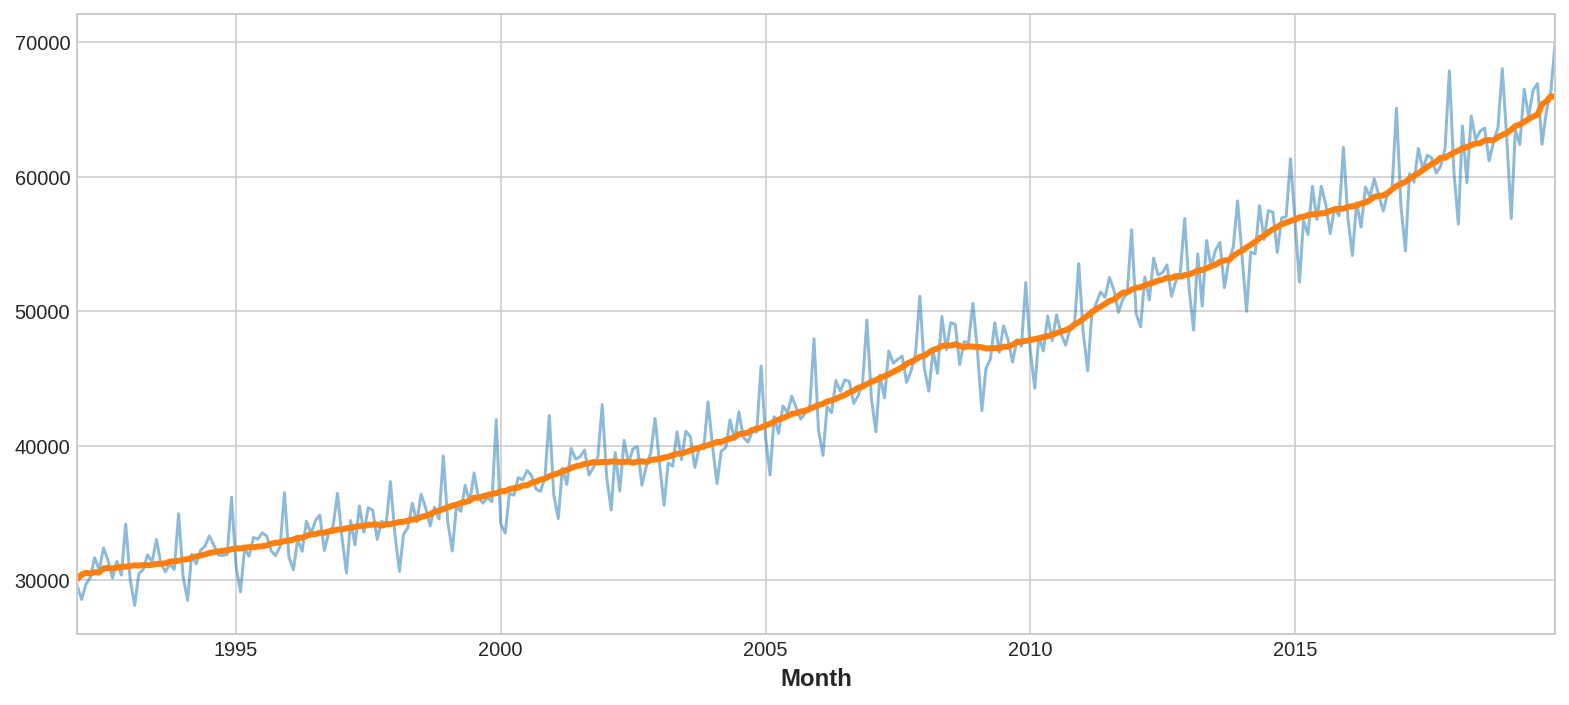

In [11]:
# moving average
trend = food_sales.rolling(
    window=12,  # window size, 관측치 개수
    center=True,  # window label 을 window index 중간 값으로 설정
    min_periods=6  # 관측치의 최소 개수, 이것보다 작으면 np.nan
).mean()

ax = food_sales.plot(alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

#### 2. 트렌드를 확인하기  
가장 적합한 order polynomial trend 는 무엇인가? 더 나은 non-polynomial curve 가 존재할까?  

트렌드에서 위로 향하는 구부러짐은 order 2 (quadratic) polynomial 이 적절하다고 판단할 수 있다.  
하지만, 위의 경우는 percent change 로 가장 잘 표현된다. Percent change 는 주로 exponential curve 를 이용하여 모델링 된다.  

average_sales 데이터에 대해서도 moving average 를 적용해보자.

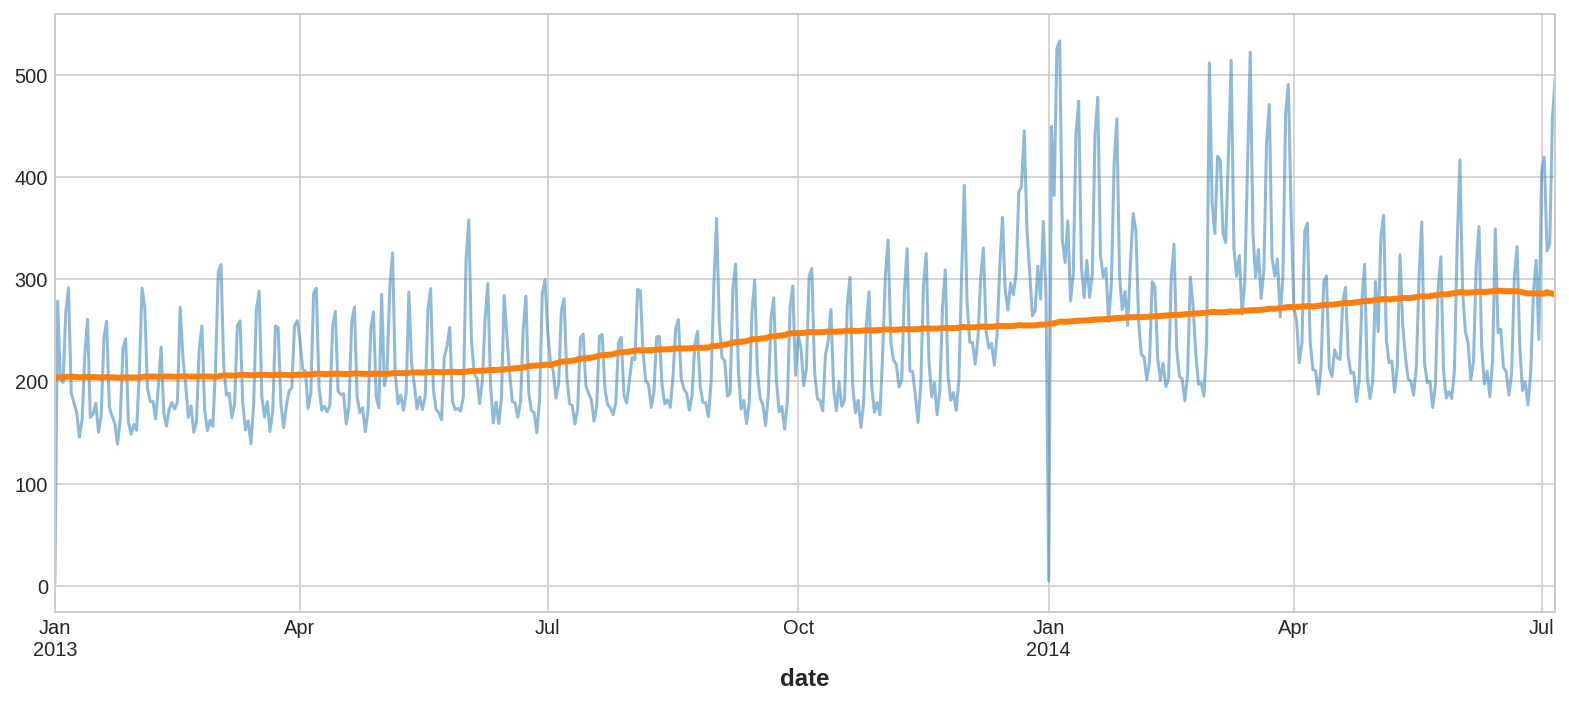

In [12]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183
).mean()
ax = average_sales.plot(alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

#### 3. trend feature 를 만들기  
DeterministicProcess 를 이용하여 cubic trend model 에 적함한 feature 를 생성할 수 있다.  

In [13]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()
y.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

In [14]:
dp = DeterministicProcess(
    index=y.index,  # feature 를 만들려는 시간
    order=3
)

# feature
X = dp.in_sample()
# feature for 90-day forecast
X_fore = dp.out_of_sample(steps=90) 

In [15]:
X.head()

,trend,trend_squared,trend_cubed
date,,,
2013-01-01,1.0,1.0,1.0
2013-01-02,2.0,4.0,8.0
2013-01-03,3.0,9.0,27.0
2013-01-04,4.0,16.0,64.0
2013-01-05,5.0,25.0,125.0


In [16]:
X_fore.head()

,trend,trend_squared,trend_cubed
2014-07-07,552.0,304704.0,168196608.0
2014-07-08,553.0,305809.0,169112377.0
2014-07-09,554.0,306916.0,170031464.0
2014-07-10,555.0,308025.0,170953875.0
2014-07-11,556.0,309136.0,171879616.0


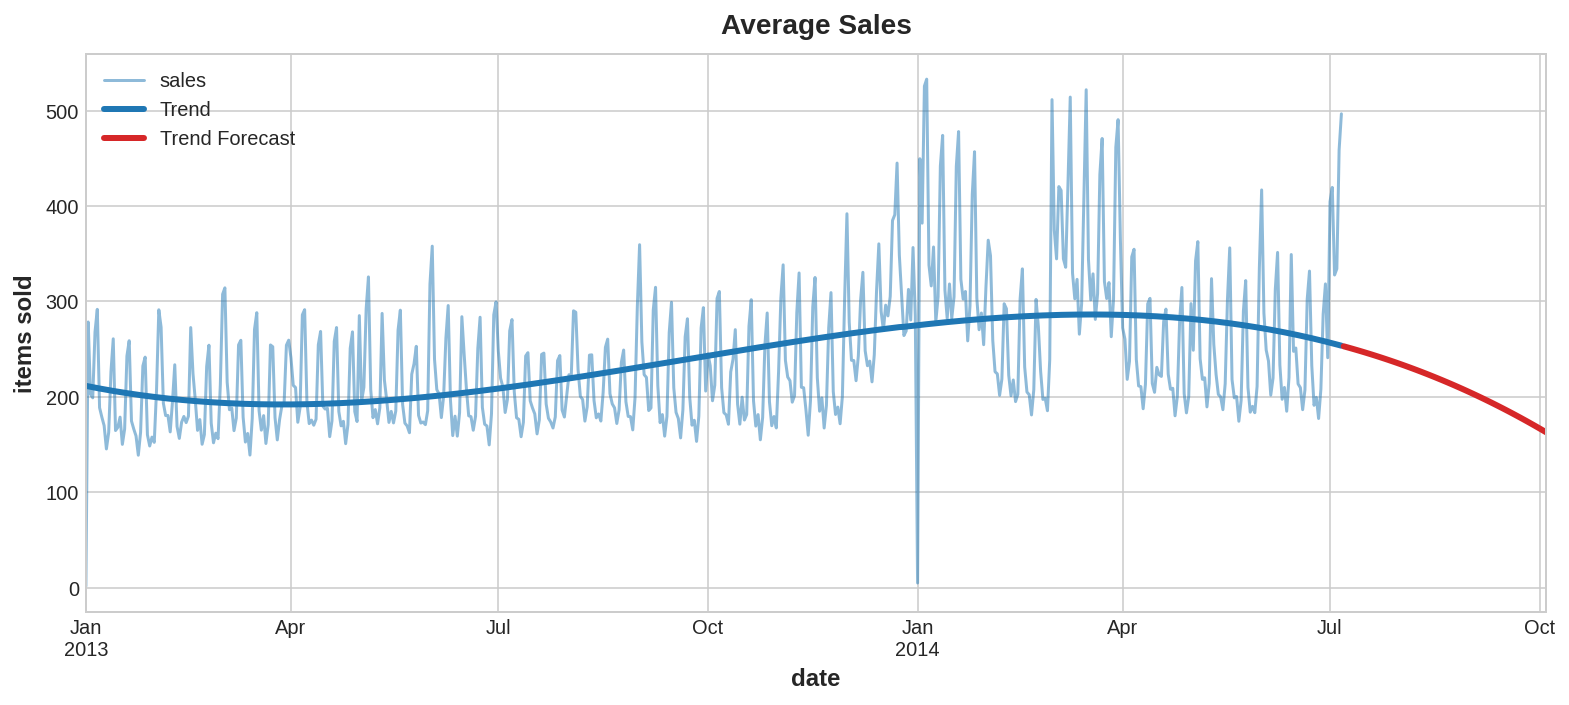

In [18]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, title='Average Sales', ylabel='items sold')  # target time series
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0')  # validate
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3')  # forecast
ax.legend()

복잡한 트렌드를 학습하는 방법 중 하나로 polynomial 의 order 를 늘릴 수 있다. 예를 들어서 11 order 를 사용해보자

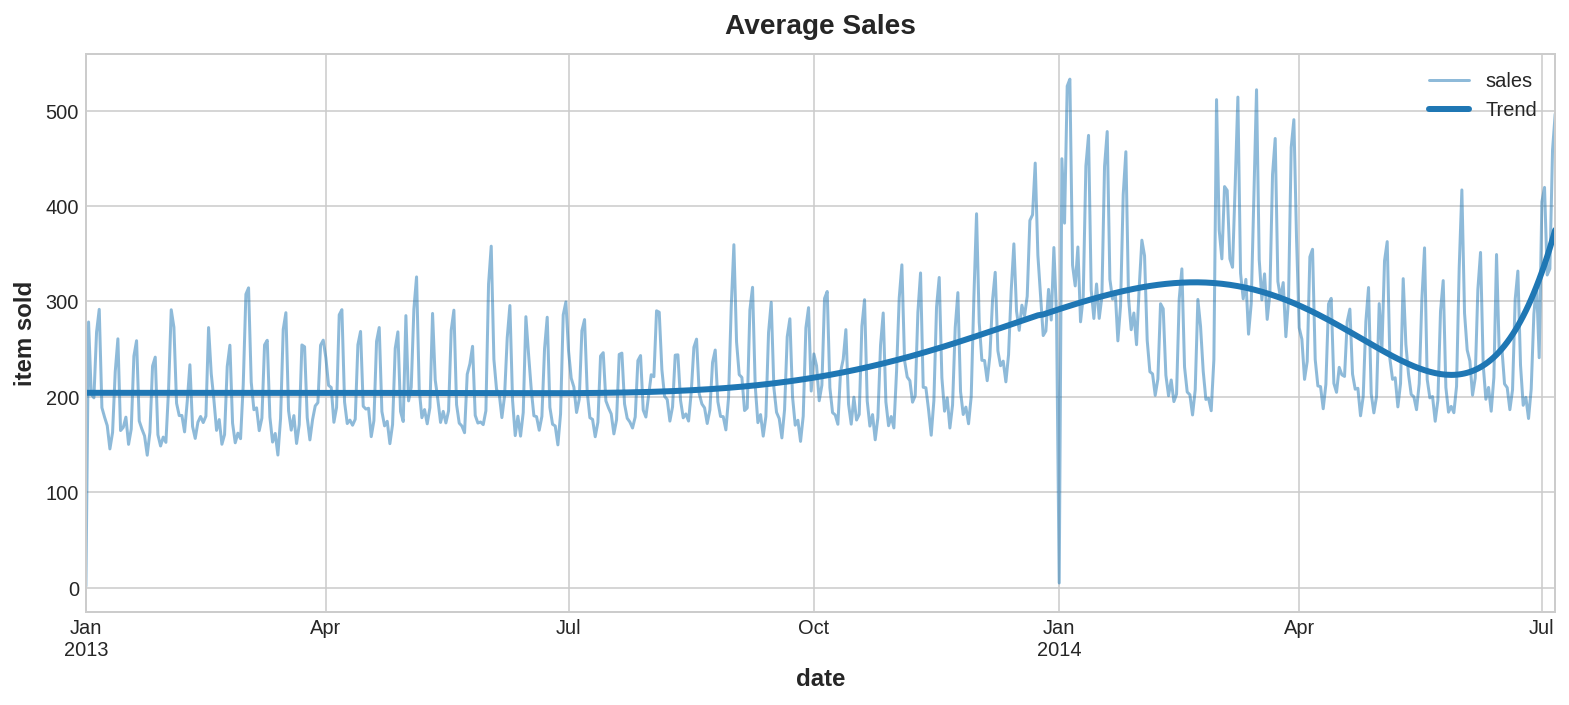

In [19]:
dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="item sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color="C0")
ax.legend()

#### 4. High-order polynomial 로 예측하는 것의 risk 를 이해하자  
High-order polynomial 은 예측에 적합하지 않은 경우가 대부분이다. 왜 그럴까?  

order 11 polynomial 의 항은 t \*\* 11 과 같은 형태이다.  이러한 수식은 학습한 period 를 벗어날 때, 더 빠르게 발산하는 경향이 있다.  
즉, forecast 의 신뢰도가 급격히 떨어진다.  

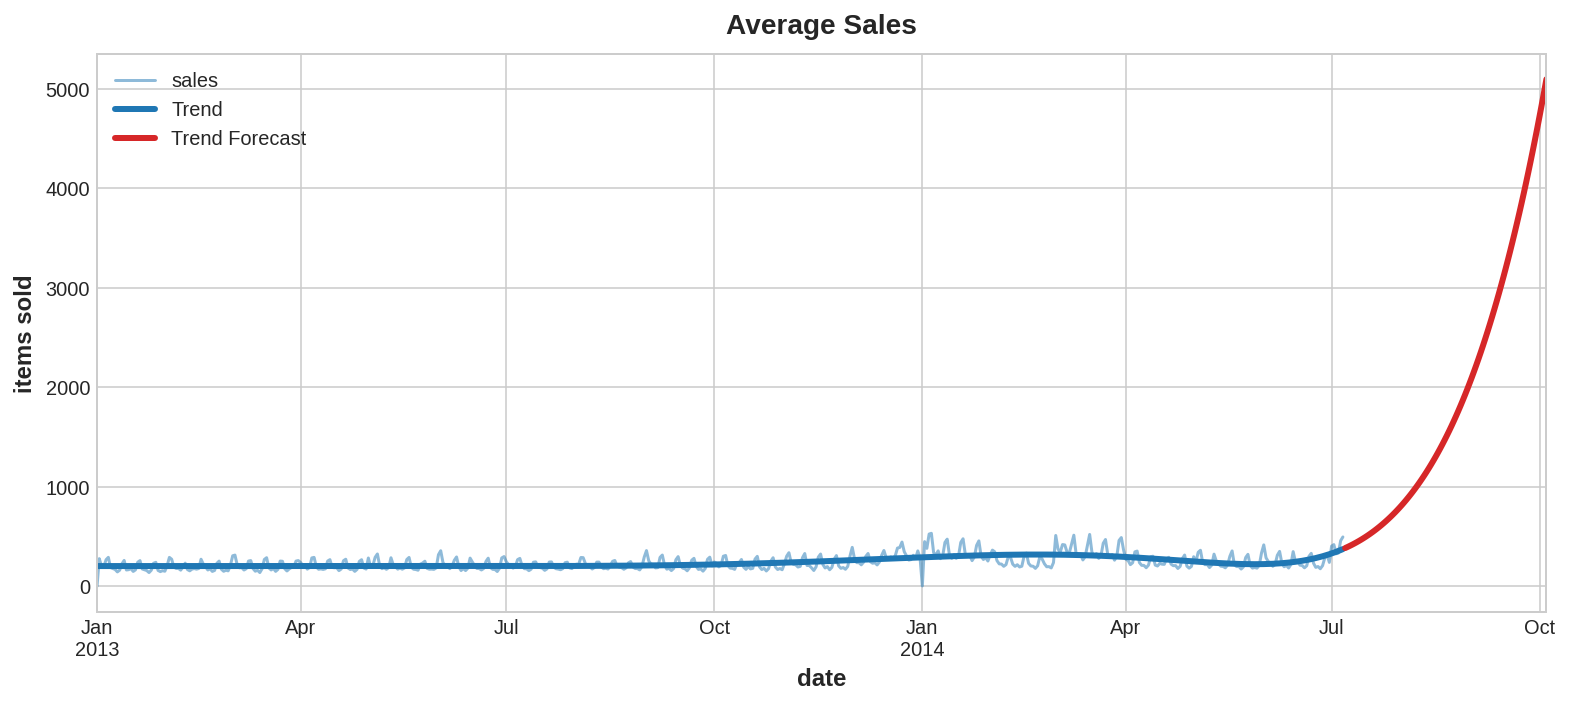

In [20]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

#### 5. spline 곡선을 이용한 트렌드 학습  
spline 은 polynomial 보다 트렌드 학습에 좋은 대안이 될 수 있다.  
pyearth 라이브러리의 Multivariate Adaptive Regression Splines (MARS) 알고리즘은 강력하고 사용하기 쉽다.  

spline curve ?  
: 주어진 점을 통과하는 부드러운 곡선  
: 인접한 두 점 사이의 구간마다 별도의 다항식을 이용하여 곡선을 정의함  

In [26]:
!pip install git+https://github.com/scikit-learn-contrib/py-earth@v0.2dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-learn-contrib/py-earth (to revision v0.2dev) to /tmp/pip-req-build-p4a0yvz6
  Running command git clone -q https://github.com/scikit-learn-contrib/py-earth /tmp/pip-req-build-p4a0yvz6
  Running command git checkout -b v0.2dev --track origin/v0.2dev
  Switched to a new branch 'v0.2dev'
  Branch 'v0.2dev' set up to track remote branch 'v0.2dev' from 'origin'.
  Created wheel for sklearn-contrib-py-earth: filename=sklearn_contrib_py_earth-0.1.0+16.g400f84d-cp37-cp37m-linux_x86_64.whl size=3997274 sha256=7bbd6c39181a0430b6eb1bb40c308176e14d1aaac80ff68db178b335c02fc9b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ev3oj_7w/wheels/79/d7/aa/1e418a9aea84424ef2ce2697ae7cccace322976388d3692e8e
Successfully built sklearn-contrib-py-earth


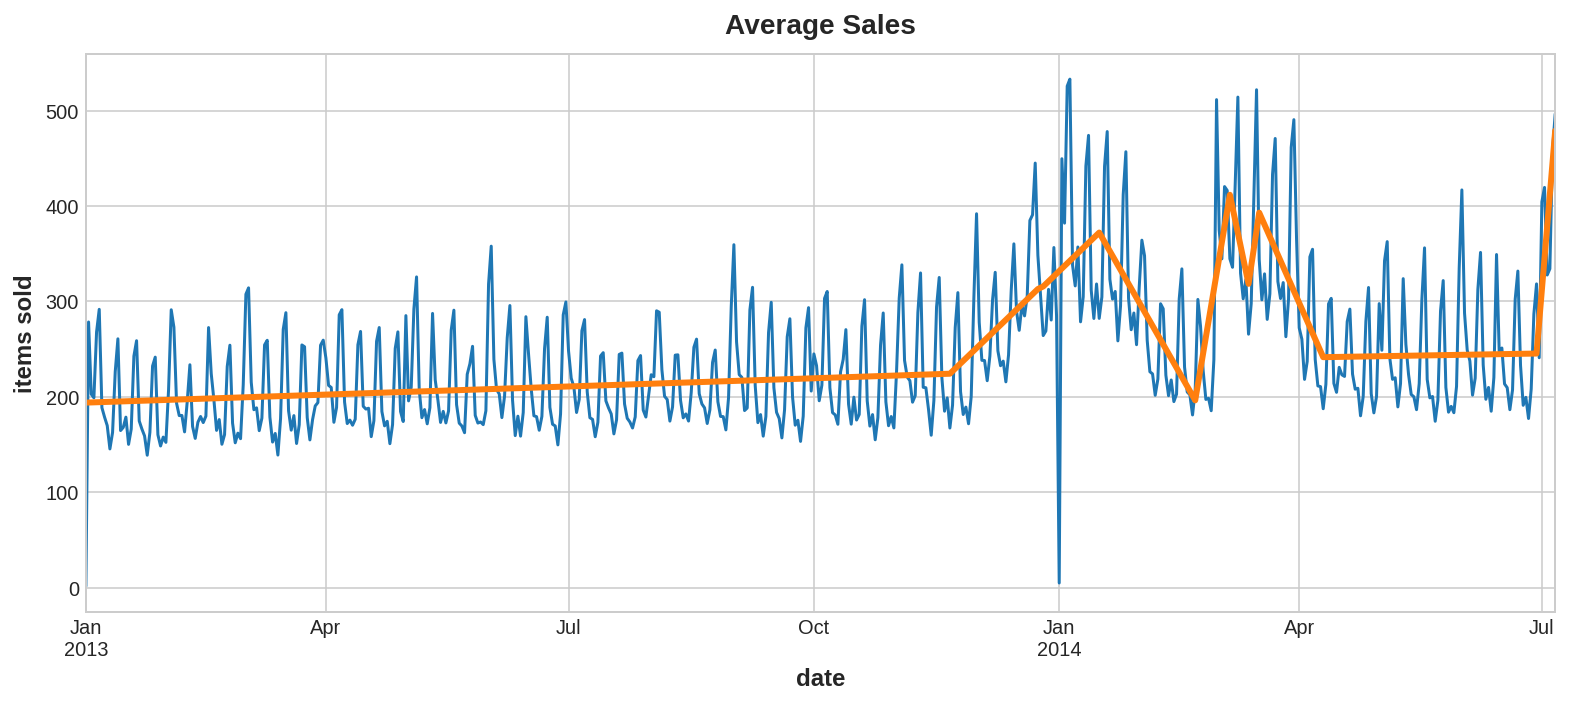

In [27]:
from pyearth import Earth

y = average_sales.copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

spline 곡선을 이용하여 트렌드를 추출하고 detrending 하여 한 시계열 내의 다른 트렌드 패턴들을 고립시킬 수 있다.  

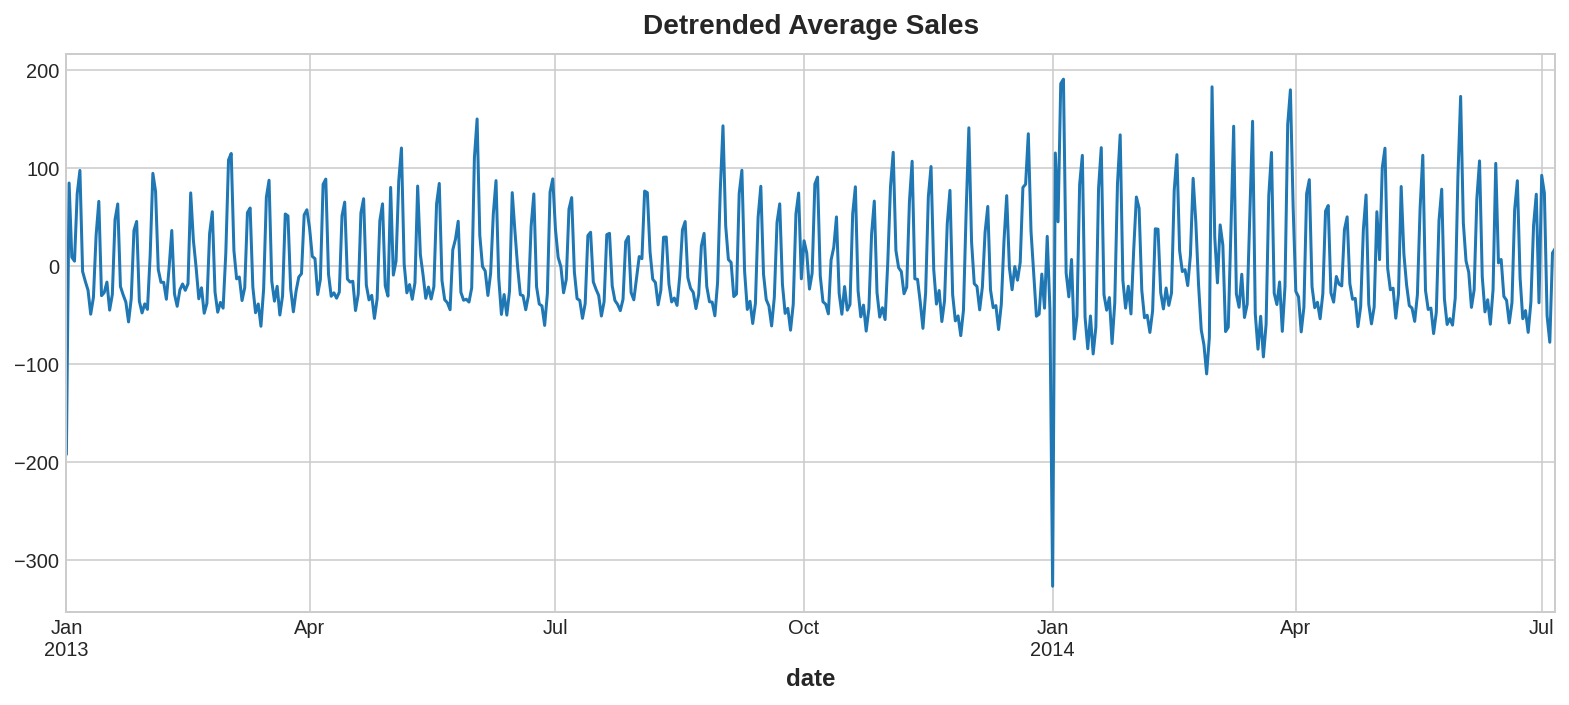

In [28]:
# store sales 데이터에서 트렌드를 제거
y_detrended = y - y_pred
y_detrended.plot(title="Detrended Average Sales")